# Primary components, Lasso, Ridge Regression, and PCA  

In this notebook, we will be looking at a data set containing 7128 gene expressions for 72 patients with leukaemia. There are two different leukaemia types included in the data set, and we want to see if there is a set of genes
which can help distinguish between the two. Let's read in our data



In [5]:
## data.leuk = read.csv("http://web.stanford.edu/~hastie/CASI_files/DATA/leukemia_big.csv") # direct url for up to date data
data.leuk = read.csv("leukemia_big.csv", header=TRUE)  # local file for quicker loading 
head(data.leuk[1:5])

# Transpose
X <- t(data.leuk)

,ALL,ALL.1,ALL.2,ALL.3,ALL.4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.5336217,-0.8676096,-0.4331719,-1.6719032,-1.1876894
2,-1.2356729,-1.2755005,-1.1844922,-1.5964240,-1.3352557
3,-0.3339829,0.3759265,-0.4591960,-1.4225714,-0.7974929
4,0.4887021,0.4440110,0.4362635,0.1933529,0.2356315
5,-1.3008933,-1.2296598,-1.3258824,-1.8183288,-1.3112060
6,-1.6826682,-1.6420718,-1.4072639,-1.7444693,-1.6543805


We needed to transpose our data so that the 7128 genes become our columns, with the 72 patients as the rows. 


We will start our analysis by finding the first two primary components of the data set. Then we will fit a model using the Lasso method. Then another using ridge regression. Then a fourth model using PCA, where we will need to decide how many components to include in our model. 



## Principal components

Let's find the first two principal components to see if this
gets us closer to our goal of grouping the patients by the different
cancer types.

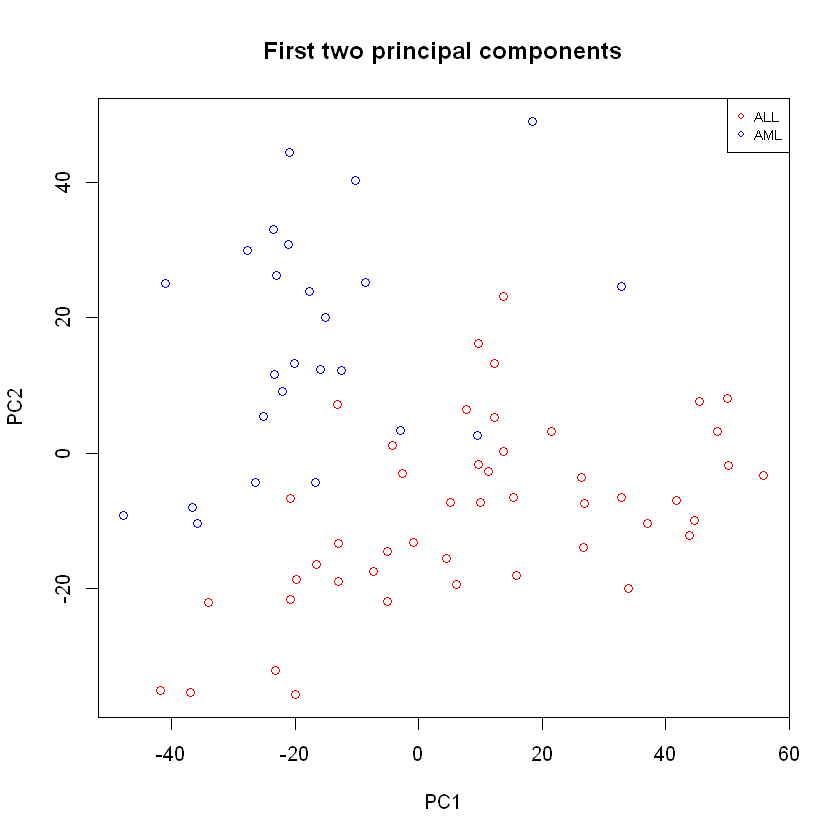

In [7]:
# Find PC
pc <- prcomp(X, scale =TRUE, center = TRUE)
# summary(pc)
# pc.std <- prcomp(X.std, scale=TRUE, center=TRUE)
# summary(pc.std) # This is here for comparison (in case it's needed later)


# Seperating cancer types
pc.all.1 <- pc$x[,1][grepl("ALL", names(pc$x[,1]))]
pc.all.2 <- pc$x[,2][grepl("ALL", names(pc$x[,2]))]
pc.aml.1 <- pc$x[,1][grepl("AML", names(pc$x[,1]))]
pc.aml.2 <- pc$x[,2][grepl("AML", names(pc$x[,2]))]
# There might be a better way to do this


# Plotting data with colored labels
plot(pc$x[,1], pc$x[,2], xlab='PC1', ylab='PC2', main='First two principal components')
points(pc.all.1, pc.all.2, col='red')
points(pc.aml.1, pc.aml.2, col='blue')
legend('topright', cex=0.7, col=c('red', 'blue'), pch=1, legend=c('ALL', 'AML'),)


The cluster of blue data points in the top left of the plot shows that the patients with AML have genetic expressions with variations close to others with the same cancer type. Further analysis of the data is needed to extract exactly which genes cause this correlation, since primary component analysis maps all of the variables onto these two axes.

## Lasso

Now, by reading in some example response data, provided on the course homepage, we can try to fit a model using the lasso method. Lasso models contain a penalty parameter, $\lambda$ , which helps decide how many relevant variables should be included in the model. As $\lambda$ decreases, the number of variables included in the model increases. Since our data has 7128 covariates, it is useful to get rid of the unnecessary ones, as they more likely represent some random noise than variance in the data, even if that means losing some precision of our model. We can estimate $\lambda$ with K-fold cross-validation. Specifically, we'll look at K=3, 10 and 72, the last one being otherwise called "leave-one-out"
cross validation. 

In [1]:
options(warn=1)

# 1b) #############
set.seed(1234567)
# Read response data
response.train <- read.csv("response_train.csv")
summary(response.train)

# Get only the values from response (not cancer types)
y.train <- response.train[,2]


# Find lambdas for lasso using 3-, 10-, and 72-fold cross validation 
library(glmnet)
lambda.l.3 <- cv.glmnet(y = y.train, x = as.matrix(X), nfolds=3, alpha = 1, standardize = TRUE)
lambda.l.10 <- cv.glmnet(y = y.train, x = as.matrix(X), nfolds=10, alpha = 1, standardize = TRUE)
lambda.l.72 <- cv.glmnet(y = y.train, x = as.matrix(X), nfolds=72, alpha = 1, standardize = TRUE)


# Look at results from lambdas 
lambda.l.3$lambda.min   # lambda = 1.5536
lambda.l.10$lambda.min  # lambda = 0.3195
lambda.l.72$lambda.min  # lambda = 0.3195


       X            V1          
 ALL    : 1   Min.   :-108.817  
 ALL.1  : 1   1st Qu.: -78.896  
 ALL.10 : 1   Median : -47.059  
 ALL.11 : 1   Mean   : -44.896  
 ALL.12 : 1   3rd Qu.:  -9.971  
 ALL.13 : 1   Max.   :  15.250  
 (Other):66                     

Warning message:
"package 'glmnet' was built under R version 3.6.3"
Loading required package: Matrix

Loaded glmnet 3.0-2




ERROR: Error in as.matrix(X): object 'X' not found


_The warning that shows up here is due to our leave-one-out cross validation._


It’s important to point out that if you do not set a seed before running this code, you can get different values for lambda.1.3 and lambda.1.10, since cv.glmnet() randomly splits your data into 3 and 10 groups. The 72-fold lambda will be the same no matter what the seed is, since each group will only have 1 variable in it. Our return lambda variables consist two parts; lambda.min and lambda.1se. For now, we are interested in the lambda that gives the lowest cross validation error, which is what lambda.min represents. 

I ran a for loop, checking multiple different seeds, to see how much
the different lambdas vary according to how the data set is split. It
turns out, the 3-fold-cv changed the most every iteration, ranging
from almost equal to lambda.l.10 and lambda.l.72 to almost 5-6
times them. This means that the $\lambda$ found by 3-fold cross validation
is not accurate enough to use. For most cases, the 10-fold-cv lambda
is equal, or at least very close, to the leave-one-out lambda. Since a 10-
fold calculation is much cheaper (takes less computing power) than
a 72-fold-cv, I chose to use this lambda.l.10 as the "optimal $\lambda$".